# Solve the handwritten math equation

Tasks:
- Load the image with Math equation
- Transform and segment each symbol from the image into smaller images
- Use the trained model to classify each small image to corresponding math symbol
- Evaluate the predicted expression and display the result

## Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import torch
from torch import nn, functional, optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms


## Load the test image

In [2]:
test_img_file_path = 'data/test_two_plus_thirty_five.png'
# test_img_file_path = 'data/test_sixty_eight_plus_seventy_one.png'

In [3]:
img = cv2.imread(test_img_file_path)
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgray = ~imgray

In [4]:
def imshow(imgray):
    plt.imshow(imgray)
    plt.axis('off')
    plt.show()

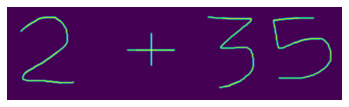

In [5]:
imshow(imgray)

## Transform and segment the image into smaller images

In [6]:
ret, thresh = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY)
# contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cnt = sorted(contours, key = lambda ctr: cv2.boundingRect(ctr)[0])

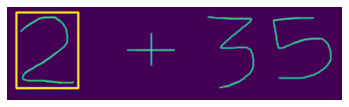

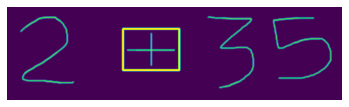

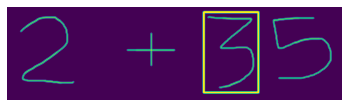

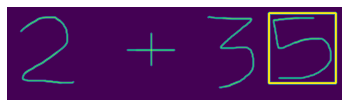

In [7]:
w, h = (28,28)
extra_padding = 13

char_boxes = []

for c in cnt:
    x, y, w, h = cv2.boundingRect(c)
    x_left, y_left = x-extra_padding, y-extra_padding
    x_right, y_right = x+w+extra_padding, y+h+extra_padding
    img_rect = cv2.rectangle(imgray.copy(), (x_left, y_left), (x_right, y_right), (255,255,0), 5)
    imshow(img_rect)
    # print(x, y, w, h)
    char_boxes.append([x_left,y_left,w+extra_padding,h+extra_padding])


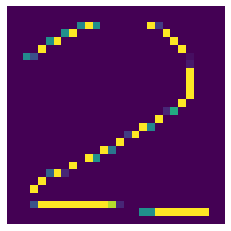

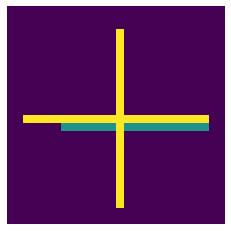

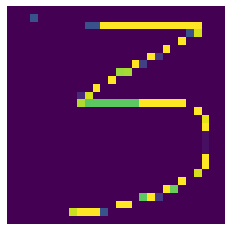

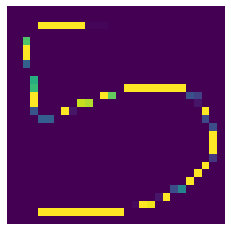

In [8]:
test_data = []

bool_rect=[]
for r in char_boxes:
    l=[]
    for rec in char_boxes:
        flag=0
        if rec != r:
            if r[0]<(rec[0]+rec[2]+10) \
                and rec[0]<(r[0]+r[2]+10) \
                and r[1]<(rec[1]+rec[3]+10) \
                and rec[1]<(r[1]+r[3]+10):
                flag=1
            l.append(flag)
        else:
            l.append(0)
    bool_rect.append(l)
#print(bool_rect)
dump_rect=[]
for i in range(len(cnt)):
    for j in range(len(cnt)):
        if bool_rect[i][j]==1:
            area1=char_boxes[i][2]*char_boxes[i][3]
            area2=char_boxes[j][2]*char_boxes[j][3]
            if(area1==min(area1,area2)):
                dump_rect.append(char_boxes[i])
#print(len(dump_rect)) 
final_rect=[i for i in char_boxes if i not in dump_rect]
#print(final_rect)
for r in final_rect:
    x=r[0]
    y=r[1]
    w=r[2]
    h=r[3]
    im_crop =thresh[y:y+h+10,x:x+w+10]


    im_resize = cv2.resize(im_crop,(28,28))
    imshow(im_resize)

    im_resize=np.reshape(im_resize,(784, 1))
    test_data.append(im_resize/255)

## Classify each small image to math symbol using trained model

In [9]:
class NN_Classifier(nn.Module):
    def __init__(self, classes_len):
        super(NN_Classifier,self).__init__()
        self.cnn_1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, stride=1, padding=0)
        self.cnn_2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(p=0.2)
        self.dropout2d = nn.Dropout2d(p=0.2)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64) 
        self.out = nn.Linear(64, classes_len) 
        
    def forward(self,x):
        
        out = self.cnn_1(x)
        out = self.relu(out)
        out = self.dropout2d(out)
        out = self.maxpool(out)
        
        out = self.cnn_2(out)
        out = self.relu(out)
        out = self.dropout2d(out)
        out = self.maxpool(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.out(out)
        
        return out

In [10]:
# Load the trained model from filepath
loaded_model = torch.load('data/model_acc_88.pth')
loaded_model.eval()

NN_Classifier(
  (cnn_1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (cnn_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (dropout2d): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=15, bias=True)
)

In [11]:
X_test = torch.tensor(test_data)

test = torch.utils.data.TensorDataset(X_test)

test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle = False)


In [12]:
classes = ['+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=',
       '/', '*']

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [14]:
s = ''
with torch.no_grad():
    for inputs in test_loader:
        for input_ in inputs:
#             print(input_.shape)
            input_ = Variable(input_.view(-1,1,28,28))
#             print(input_.shape)

            input_ = input_.to(device)

            outputs = loaded_model(input_)
            _, preds = torch.max(outputs, 1)

            s = s + classes[preds[0]]

print(s)

2+35


## Evaluate the predicted expression

In [15]:
eval(s)

37